# Loading Packages

In [2]:
import Pkg
Pkg.activate("./dibs_env")

install_run = false
if install_run
    ENV["PYTHON"]=""
    Pkg.instantiate()
    using Conda
    Conda.add("dustmaps")
#     Pkg.add(["Glob","FITSIO","Serialization", "HDF5", "DelimitedFiles"])
#     Pkg.add(["StatsBase","Distributions","FreqTables", "LsqFit"])
#     Pkg.add(["BinnedStatistics","KrylovKit","ImageTransformations"])
#     Pkg.add(["DataFrames", "ProgressMeter", "Distributed", "BenchmarkTools"])
#     Pkg.add(["Healpix", "SkyCoords", "WCS"])
#     Pkg.add(["LaTeXStrings", "Formatting", "Printf", "PyFormattedStrings"])
#     Pkg.add(["Conda","PyCall","PyPlot
end

#File Handling
using Glob, FITSIO, Serialization, HDF5, DelimitedFiles
# Stats
using StatsBase, LinearAlgebra, Distributions, FreqTables, LsqFit 
using BinnedStatistics, KrylovKit, ImageTransformations
# Computing
using DataFrames, ProgressMeter, Distributed, BenchmarkTools, Random
# Astro
using Healpix, SkyCoords, WCS
# Python Plotting Setup
using PyCall, LaTeXStrings, Formatting, Printf, PyFormattedStrings
import PyPlot; const plt = PyPlot
mpltk=pyimport("mpl_toolkits.axes_grid1")
patches=pyimport("matplotlib.patches")
mplcolors=pyimport("matplotlib.colors")
mplani = pyimport("matplotlib.animation");
cc=pyimport("colorcet")
pyimport("sys")."stdout" = PyTextIO(stdout)
pyimport("sys")."stderr" = PyTextIO(stderr);
py"""
from scipy.stats import binned_statistic_2d
"""

if install_run
    py"""
    from dustmaps.config import config
    config.reset()
    """
end
plt.matplotlib.style.use("dark_background")

  Activating project at `/uufs/chpc.utah.edu/common/home/sdss50/sdsswork/users/u6039752/zenodo/GaiaDIB/notebooks/dibs_env`


# Clean Injection Test Geneation

In [3]:
xmin0 = 8460
xmax0 = 8700
wavex = xmin0:0.1:xmax0

SNR_lst = h5read("../priors/SNR_lst.h5","SNR_lst");
star_msk, nansum = deserialize("../priors/star_mask.jdat");

In [4]:
#These are all a permutation off of my sorted ordering of the Gaia spectra
f = FITS("../gaia_archive_results/RVS_astro-result.fits.gz")
astro_source_id = read(f[2],"source_id")
flags_gspspec = read(f[2],"flags_gspspec");
close(f)

f = FITS("../gaia_archive_results/RVS_source-result.fits.gz")
RVS_source_id = read(f[2],"source_id")
ra = read(f[2],"ra")
dec = read(f[2],"dec")
close(f)

ps = sortperm(RVS_source_id);

In [5]:
grvs = h5open("../sources/gaia_rvs_lite.h5");
grvs_id = read(grvs["SOURCE_ID"]);
glon = read(grvs["GLON"]);
glat = read(grvs["GLAT"]);

py"""
from astropy.coordinates import SkyCoord
import astropy.units as units
from dustmaps.sfd import SFDWebQuery
sfd = SFDWebQuery()
l = $glon
b = $glat
coords = SkyCoord(l*units.deg, b*units.deg, frame='galactic')
sfd_reddening = sfd(coords)
"""

sfd_red = 1 .* py"sfd_reddening";

In [6]:
function mask_gspspec_flag(flagstring)
    good = true
    if length(flagstring)==41
        for i=1:13
            good &= (flagstring[i].=='0')
        end
        return good
    else
        good = false
        return good
    end
end

mask_gspspec_flag (generic function with 1 method)

In [7]:
msk_flags_gspspec = mask_gspspec_flag.(flags_gspspec[ps]);
msk_in = nansum .& (sfd_red.<0.05) .& msk_flags_gspspec
count(msk_in), count(msk_in)/length(msk_in)

(65186, 0.06520914924798303)

In [8]:
testset = (1:length(SNR_lst))[msk_in];
extrema(SNR_lst[msk_in])

(20.191105079867555, 1825.3814399663006)

Defining the parent set of spectra that will be used for injection, high quality upstream processing and low dust foreground

In [10]:
mu0, sig0 = 1.85, 0.5
mu1, sig1 = 8623.47, 1

seed =2022
rng = MersenneTwister(seed)
nsamp = 1000000

d = Uniform(mu0-2.5*sig0, mu0+2.5*sig0)
sig = rand(rng,d,nsamp);

d = Uniform(mu1-5*sig1, mu1+5*sig1)
x0_arr = rand(rng,d,nsamp);

d = Uniform(-0.25, 0)
td = truncated(d, -Inf, 0.0)
amp_arr = rand(rng,td,nsamp);

drawnum = rand(rng,testset,nsamp);

This is the random draw for the injection parameters, seeded of course for reproducibility.

In [11]:
mu0-2.5*sig0, mu0+2.5*sig0, mu1-5*sig1, mu1+5*sig1

(0.6000000000000001, 3.1, 8618.47, 8628.47)

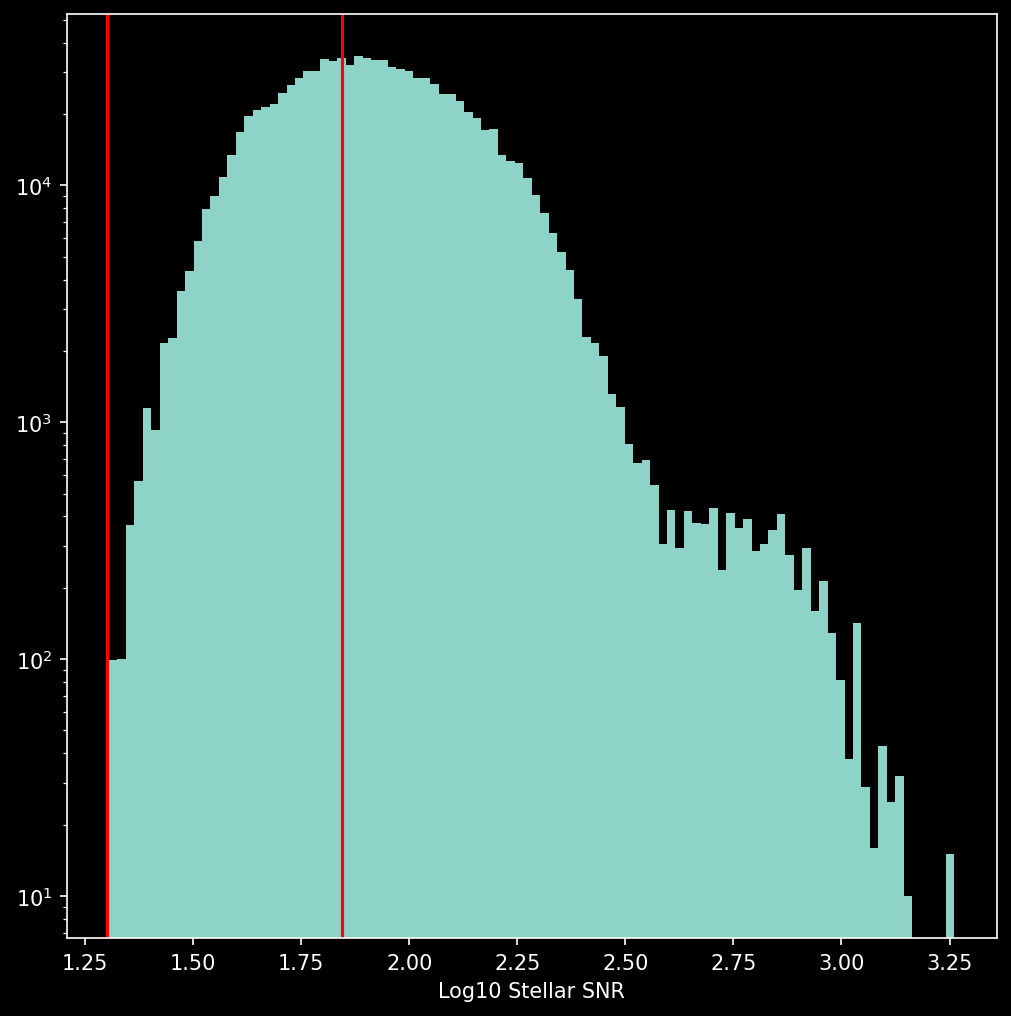

In [19]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(1,1,1)
ax.hist(log10.(SNR_lst[drawnum]),
    bins=100,
    );
ax.axvline(log10(20),color="red")
ax.axvline(log10(70),color="red")
ax.set_yscale("log")

ax.set_xlabel("Log10 Stellar SNR");

Distribution of the parent SNR used in the injection test sample. Red lines indicate region excluded from consideration by previous works because the stellar SNR was too low.

In [11]:
h5write("../sources/injection_test_gt.h5","sigma",sig)
h5write("../sources/injection_test_gt.h5","lamda",x0_arr)
h5write("../sources/injection_test_gt.h5","amp",amp_arr)
h5write("../sources/injection_test_gt.h5","testind",drawnum)
h5write("../sources/injection_test_gt.h5","snr",SNR_lst[drawnum]);

In [14]:
foldname="out/prod"
grvs = h5open("../sources/gaia_rvs.h5");
μ_bd_mat0 = h5open("../$foldname"*"_wu_full/scan_μ_bd0.h5");

In [15]:
tstind = testset[39]
x_d_flux = grvs["flux"][:,tstind];
μ_bd0 = μ_bd_mat0["μ_bd0"][:,tstind];

In [16]:
gtemp = zeros(size(μ_bd0,1));

function gauss1d!(y,amp,x0,sigma,pixcoord)
    y .+= amp .* exp.(-0.5 .*((pixcoord.-x0)./sigma).^2)./(sqrt(2*pi))
    return
end

gauss1d! (generic function with 1 method)

In [17]:
new_flux = zeros(Float64,length(wavex),nsamp)
new_dflux = zeros(Float64,length(wavex),nsamp);

In [19]:
@showprogress for draw_indx = 1:nsamp
    tstind = drawnum[draw_indx]
    sigma = sig[draw_indx]
    x0 = x0_arr[draw_indx]
    amp = amp_arr[draw_indx]
    
    x_d_flux = grvs["flux"][:,tstind]
    x_d_dflux = grvs["dflux"][:,tstind]
    μ_bd0 = μ_bd_mat0["μ_bd0"][:,tstind]
    
    fill!(gtemp,0)
    gauss1d!(gtemp,amp,x0,sigma,wavex)
    
    view(new_flux,:,draw_indx) .= x_d_flux .+ μ_bd0.*gtemp
    view(new_dflux,:,draw_indx) .= x_d_dflux
end

Progress: 100%|█████████████████████████████████████████| Time: 0:04:00:36


In [20]:
h5write("../sources/inject_test.h5","flux",new_flux)
h5write("../sources/inject_test.h5","dflux",new_dflux)

Write the new injection spectra to disk.

# Wild Injection Test Generation

This is the cut used to make the stellar prior. We want to be orthogonal to our training data.

In [20]:
msk_inter = nansum .& (SNR_lst.>70) .& (sfd_red.<0.05) .& msk_flags_gspspec
count(msk_inter), count(msk_inter)/length(msk_inter)

(39657, 0.039671083234548266)

These are wild because they include stellar types that are very poorly handled by the upstream processing.

In [21]:
msk_wild = nansum .& (sfd_red.<0.05) .& (.!msk_inter)
count(msk_wild), count(msk_wild)/length(msk_wild)

(213813, 0.21388893057035246)

In [22]:
testset = (1:length(SNR_lst))[msk_wild];
extrema(SNR_lst[msk_wild])

(14.718843233649064, 1976.313851654983)

In [23]:
mu0, sig0 = 1.85, 0.5
mu1, sig1 = 8623.47, 1

seed =2022
rng = MersenneTwister(seed)
nsamp = 1000000

d = Uniform(mu0-2.5*sig0, mu0+2.5*sig0)
sig = rand(rng,d,nsamp);

d = Uniform(mu1-5*sig1, mu1+5*sig1)
x0_arr = rand(rng,d,nsamp);

d = Uniform(-0.25, 0)
td = truncated(d, -Inf, 0.0)
amp_arr = rand(rng,td,nsamp);

drawnum = rand(rng,testset,nsamp);

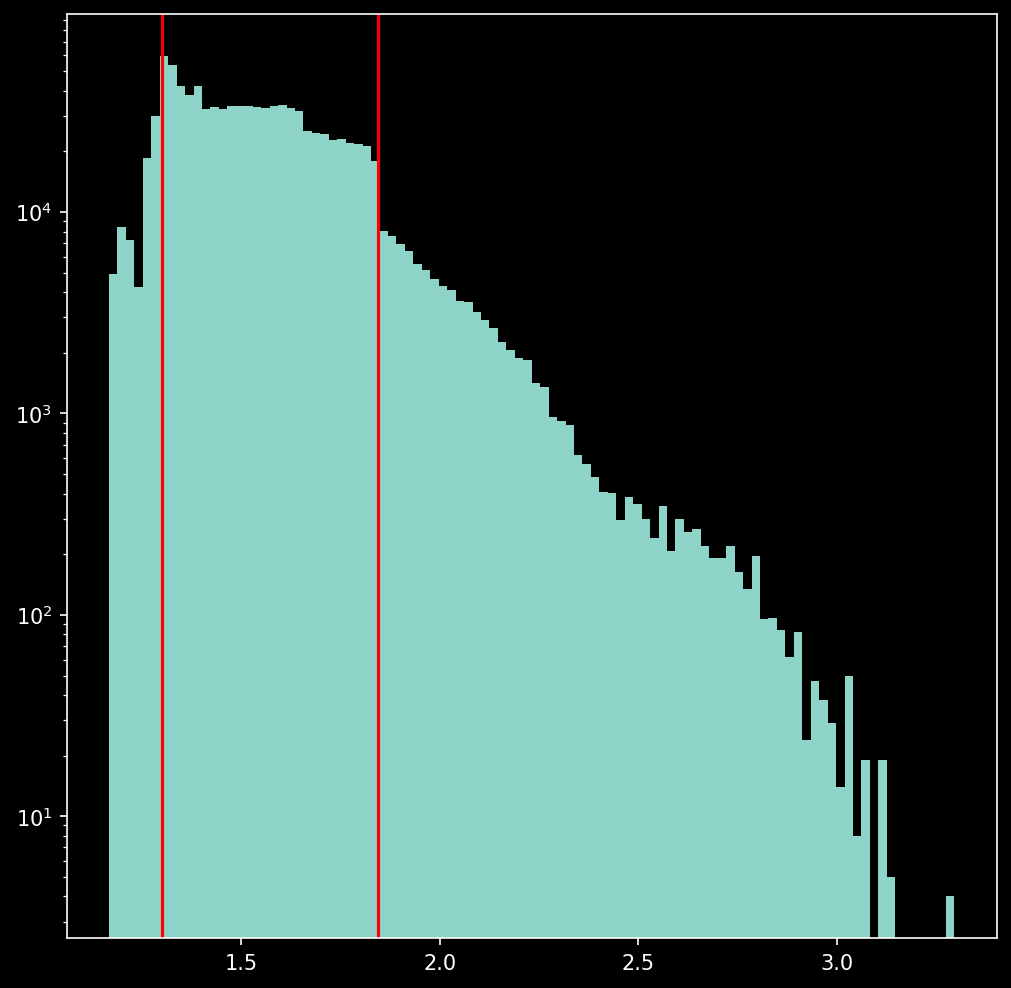

In [24]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(1,1,1)
ax.hist(log10.(SNR_lst[drawnum]),
    bins=100,
    );
ax.axvline(log10(20),color="red")
ax.axvline(log10(70),color="red")
ax.set_yscale("log")

In [26]:
h5write("../sources/injection_test_wild_gt.h5","sigma",sig)
h5write("../sources/injection_test_wild_gt.h5","lamda",x0_arr)
h5write("../sources/injection_test_wild_gt.h5","amp",amp_arr)
h5write("../sources/injection_test_wild_gt.h5","testind",drawnum)
h5write("../sources/injection_test_wild_gt.h5","snr",SNR_lst[drawnum]);

In [26]:
foldname="out/prod"
grvs = h5open("../sources/gaia_rvs.h5");
μ_bd_mat0 = h5open("../$foldname"*"_wu_full/scan_μ_bd0.h5");

In [29]:
tstind = testset[39]
x_d_flux = grvs["flux"][:,tstind];
μ_bd0 = μ_bd_mat0["μ_bd0"][:,tstind];

In [27]:
gtemp = zeros(size(μ_bd0,1));

function gauss1d!(y,amp,x0,sigma,pixcoord)
    y .+= amp .* exp.(-0.5 .*((pixcoord.-x0)./sigma).^2)./(sqrt(2*pi))
    return
end

gauss1d! (generic function with 1 method)

In [32]:
fill!(new_flux,0) # new_flux = zeros(Float64,length(wavex),nsamp)
fill!(new_dflux,0) # new_dflux= zeros(Float64,length(wavex),nsamp);

In [33]:
@showprogress for draw_indx = 1:nsamp
    tstind = drawnum[draw_indx]
    sigma = sig[draw_indx]
    x0 = x0_arr[draw_indx]
    amp = amp_arr[draw_indx]
    
    x_d_flux = grvs["flux"][:,tstind]
    x_d_dflux = grvs["dflux"][:,tstind]
    μ_bd0 = μ_bd_mat0["μ_bd0"][:,tstind]
    
    fill!(gtemp,0)
    gauss1d!(gtemp,amp,x0,sigma,wavex)
    
    view(new_flux,:,draw_indx) .= x_d_flux .+ μ_bd0.*gtemp
    view(new_dflux,:,draw_indx) .= x_d_dflux
end

Progress: 100%|█████████████████████████████████████████| Time: 0:03:03


In [34]:
h5write("../sources/inject_test_wild.h5","flux",new_flux)
h5write("../sources/inject_test_wild.h5","dflux",new_dflux)